In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/dynamics/julia/demos/quad_2d`


In [2]:
# Pkg.add("Revise");

In [417]:
using Revise
using ModelingToolkit, LinearAlgebra
using GLMakie
using ControlSystems
using DifferentialEquations
using StaticArrays
# using Plots

include("utilities.jl")
include("types.jl")
include("linearize.jl")

linearize_system (generic function with 1 method)

## Utilities 

In [418]:
# 2D rotation matrix
R_2D(θ::Float64) = SA_F64[cos(θ) -sin(θ); sin(θ) cos(θ)];

In [419]:
motor_left = BLDCMotor(0, 12.5);
motor_right = BLDCMotor(0, 12.5);

quad_obj = Quad2d(1.0, 0.1, 0.003, motor_left, motor_right);
sim_params = SimParams(6,2,3, 0.01);
safety_box = SafetyBox(10, 10, 10, -10, -10, 0);

# Linearization

In [420]:
# equilibrium point
x₀ = Pose2D(2,1,0,0,0,0)

const thrust_equilibirum::Float64 = 9.81;
        
const f_1_equilibirum::Float64 = thrust_equilibirum/2
const f_2_equilibirum::Float64 = thrust_equilibirum/2

sys_c, sys_d, AB_symbolic = linearize_system(sim_params.Ts, x₀, quad_obj,[f_1_equilibirum, f_2_equilibirum]);

# LQR Controller

### Design controller

In [421]:
Q       = Diagonal([1,1,1,1,1,1]) # Weighting matrix for state
R       = Diagonal([1,1]) # Weighting matrix for input

# Compute LQR gain matrix
const K::Array{Float64}  = lqr(sys_d,Q,R)

LoadError: cannot set type for global K. It already has a value or is already set to a different type.

## Discrete-time Linear Simulation

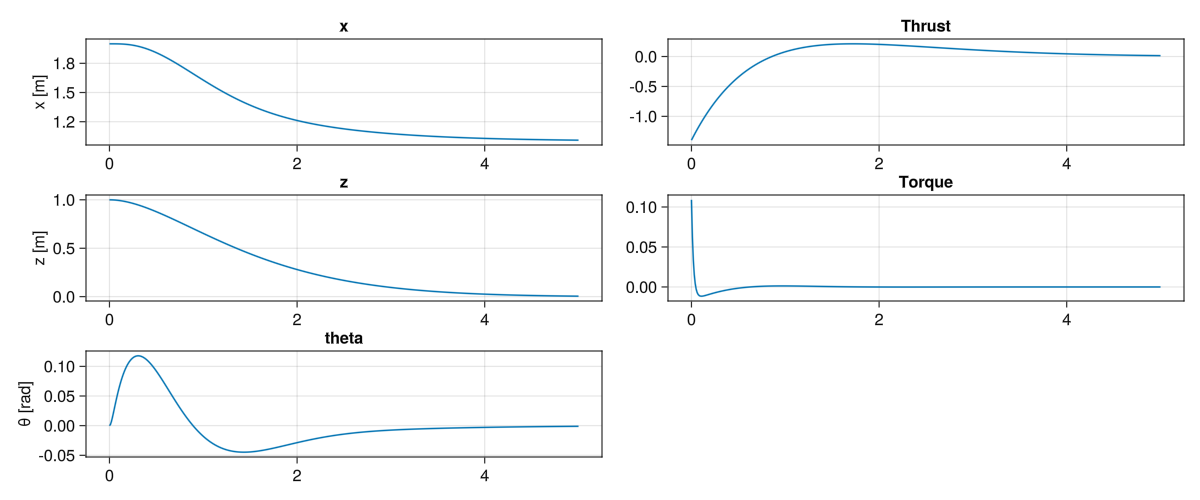

In [439]:
x_final = [1,0,0,0,0,0]

# Simulation

u_l(x,t)  = -K * (x - x_final) 
t       = 0:sim_params.Ts:5              # Time vector
x0      = [2,1,0,0,0,0]               # Initial condition

y_dl, t, x_dl, uout = lsim(sys_d,u_l,t,x0=x0)

quad_2d_plot_lsim(t,x_dl)

## Non-linear Simulation using DifferentialEquationsjl

In [458]:
function quad_2d_dynamics(X::Vector{Float64}, U::Vector{Float64}, params::NamedTuple)

    # extract the parameters
    m, g, l, I_xx = params
    
    g_vec = SA_F64[0;g] # use static array

    y = X[1]
    z = X[2]
    θ = X[3]
    ẏ = X[4]
    ż = X[5]
    θ̇ = X[6]
    
     # get the control input
    f_1 = U[1]
    f_2 = U[2]
    
    # compute thrust, torque
    f_thrust = f_1 + f_2 
    a_thrust = (f_thrust / m) # mass normalized thrust 
    
    τ = (f_1 - f_2) * l

    # translation E.O.M
    f = SA_F64[0; a_thrust]
    (ÿ, z̈) = R_2D(θ)*f + g_vec 

    # rotational E.O.M
    θ̈ = τ / I_xx

    return (ẏ, ż, θ̇, ÿ, z̈, θ̈ )
end

#Define the problem
function quad_2d(d_state, state, params, t)
    
    # extract the state
    X = state[1:sim_params.nx]

    # extract the control input
    U = state[sim_params.nx+1:end]

    (ẏ, ż, θ̇, ÿ, z̈, θ̈) = quad_2d_dynamics(X,U,params)
    
    d_state[1], d_state[2], d_state[3] = ẏ, ż, θ̇
    d_state[4], d_state[5], d_state[6] = ÿ, z̈, θ̈
end

quad_2d (generic function with 1 method)

In [459]:
# run at every timestep
condition(u,t,integrator) = true

function affect!(integrator)

     # Extract the state 
    X = integrator.u[1:sim_params.nx] 
    
    y::Float64 = X[1]
    z::Float64 = X[2]
    θ::Float64 = X[3]
    ẏ::Float64 = X[4]
    ż::Float64 = X[5]
    θ̇::Float64 = X[6]

    # # Limit operating space 
    # if z > params.safety_box.z_max
    #     z = clamp(z, params.safety_box.z_min, params.safety_box.z_max)
    #     ż = 0
    #     println("Z operational space constraint violated !")
    #     terminate!(integrator)

    # elseif z < params.safety_box.z_min
    #     z = clamp(z, params.safety_box.z_min, params.safety_box.z_max)
    #     ż = 0
    #     println("Landed !")
    #     terminate!(integrator)
    # end

    # if y < params.safety_box.y_min || y > params.safety_box.y_max
    #     y = clamp(y, params.safety_box.y_min, params.safety_box.y_max)
    #     ẏ = 0
    #     println("Y operational space constraint violated !")
    #     terminate!(integrator)
    # end

end

cb = DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

X_error: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Control: [-0.699380491655082, -0.6993804916595376]
X_error: [-5.205612008946768e-19, 0.9999300619508342, 7.426651886059135e-15, -2.0822448035786985e-16, -0.013987609833146182, 1.4853303772118427e-12]
Control: [-0.6840824302980371, -0.6840824303005268]
X_error: [-8.119249267642078e-18, 0.9997217776094728, 2.6429229175543303e-14, -1.5788741741608768e-15, -0.02766925843913181, 2.315185080684993e-12]
Control: [-0.6690211680186577, -0.6690211680199263]
X_error: [-3.852172414673911e-17, 0.9993781829082795, 5.169642491864566e-14, -4.858391822696173e-15, -0.04104968179951765, 2.7382540679354857e-12]
Control: [-0.6541936649706749, -0.6541936649711891]
X_error: [-1.1302144288837441e-16, 0.9989022667237872, 7.993605777301112e-14, -1.044168929308503e-14, -0.05413355509893629, 2.90967250293761e-12]
Control: [-0.6395969146780219, -0.6395969146780742]
X_error: [-2.556773655177952e-16, 0.9982969714813301, 1.091186400496249e-13, -1.8504413487733617e-14, -0.066925

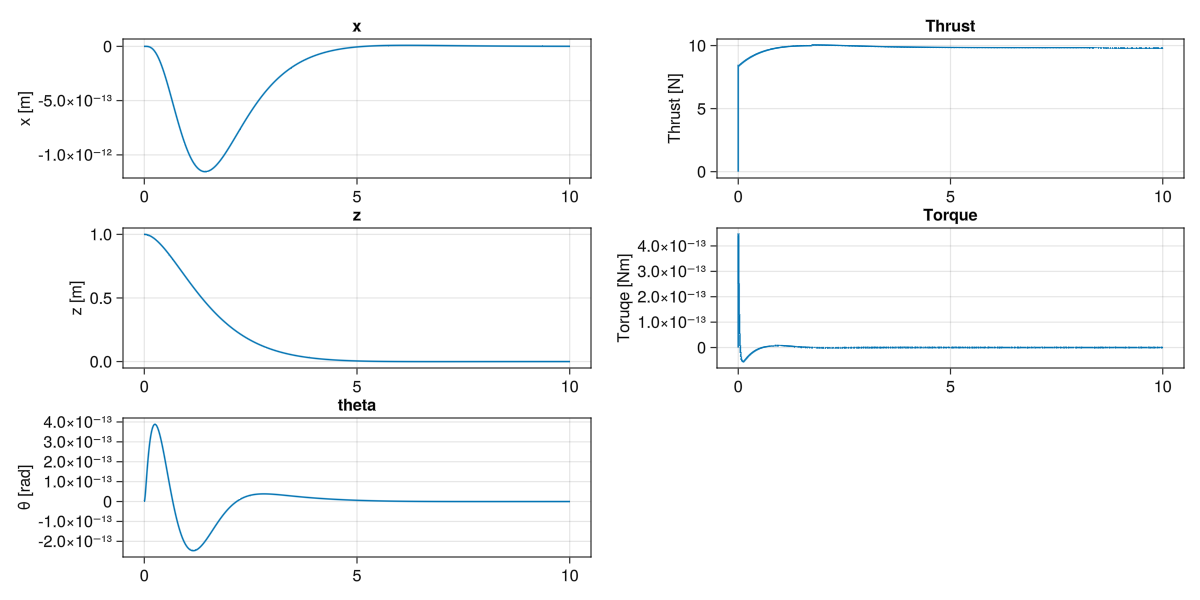

In [461]:
control_cb = PeriodicCallback(sim_params.Ts, initial_affect=true) do integrator
    nx = 6
    
    # Extract the parameters
    (; m, g, l, I_xx, safety_box, K, X_goal) = integrator.p

    # Extract the state 
    X = integrator.u[1:sim_params.nx] 

    # compute control input
    X_error = X - X_goal
    U = - K * X_error

    # println("X_req: $(X_req)")
    println("X_error: $(X_error)")
    #println("State: $(X)")

    f_1 = f_1_equilibirum + U[1]
    f_2 = f_2_equilibirum + U[2]

    # constrain the control input
    f_1 = clamp(f_1, quad_obj.motor_left.thrust_min, quad_obj.motor_left.thrust_max)
    f_2 = clamp(f_2, quad_obj.motor_right.thrust_min, quad_obj.motor_right.thrust_max)

    println("Control: $(U)")
    
    #Update the control-signal
    integrator.u[sim_params.nx+1:end] .= SA_F64[f_1, f_2]
end

#Initial Conditions
x₀ = Pose2D(0,1,0,0,0,0)

#Initial Conditions
X_final = [0,0,0,0,0,0]

# parameters
params = (; m=quad_obj.m, g=-9.81, l=quad_obj.L, I_xx = 0.003, safety_box = safety_box, K=K,  X_goal= X_final)

tspan = (0.0, 10.0);

initial_state = [x₀.y, x₀.z, x₀.θ, x₀.ẏ, x₀.ż, x₀.θ̇]; # state
u₀ = [0,0]; # control

initial_conditions = vcat(initial_state,u₀)

#Pass to solvers
cb_set = CallbackSet(control_cb,cb)
prob = ODEProblem(quad_2d, initial_conditions, tspan, params, callback=cb_set);
sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

quad_2d_plot_normal(sol)

## Benchmarking 

In [429]:
using BenchmarkTools

@btime solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

  6.541 ms (90135 allocations: 4.34 MiB)


In [431]:
@timev solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

  0.015342 seconds (90.14 k allocations: 4.341 MiB)
elapsed time (ns):  15342390
gc time (ns):       0
bytes allocated:    4552048
pool allocs:        90129
non-pool GC allocs: 6
minor collections:  0
full collections:   0


# Trajectory tracking 

### Create circle trajectory

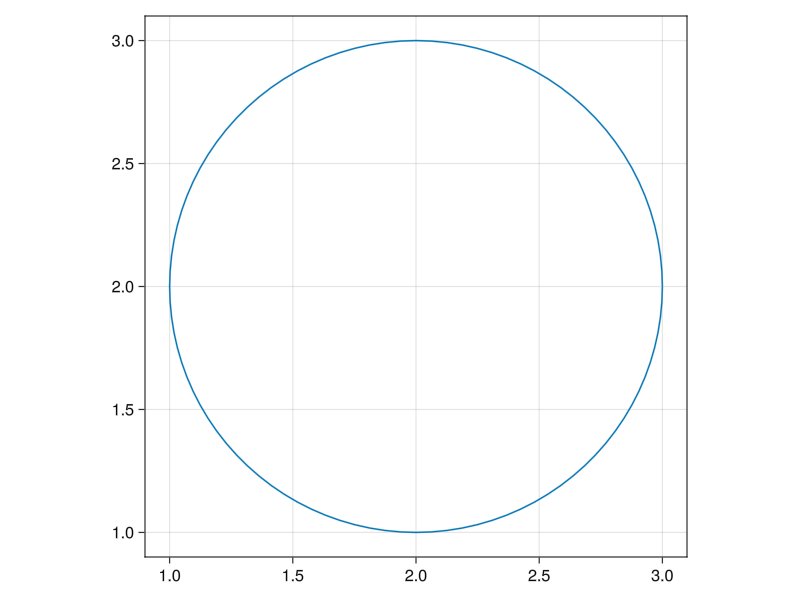

GLMakie.Screen(...)

In [432]:
include("trajectory_generation.jl")

circle_trajec_params = (r = 1, ω = 2*π, tspan = (0.0, 1.0), dt = sim_params.Ts, y₀=2, z₀=2)

x_vec, y_vec = generate_circle_trajectory(circle_trajec_params);

# @timev generate_trajectory(circle_trajec_params)
    
# plot trajectory
fig = Figure()
ax = Axis(fig[1, 1], aspect = 1)
lines!(ax, x_vec, y_vec)

display(fig)  

In [406]:
let 
include("trajectory_generation.jl")

t = 1.2 # seconds
(y_req, z_req, θ_req, ẏ_req, ż_req, θ̇_req) = generate_circle_trajectory(circle_trajec_params, 0.0)

end 

6-element Vector{Float64}:
 3.0
 2.0
 0.10158590543965393
 0.0
 0.0
 0.0

## Trajectory tracking demo

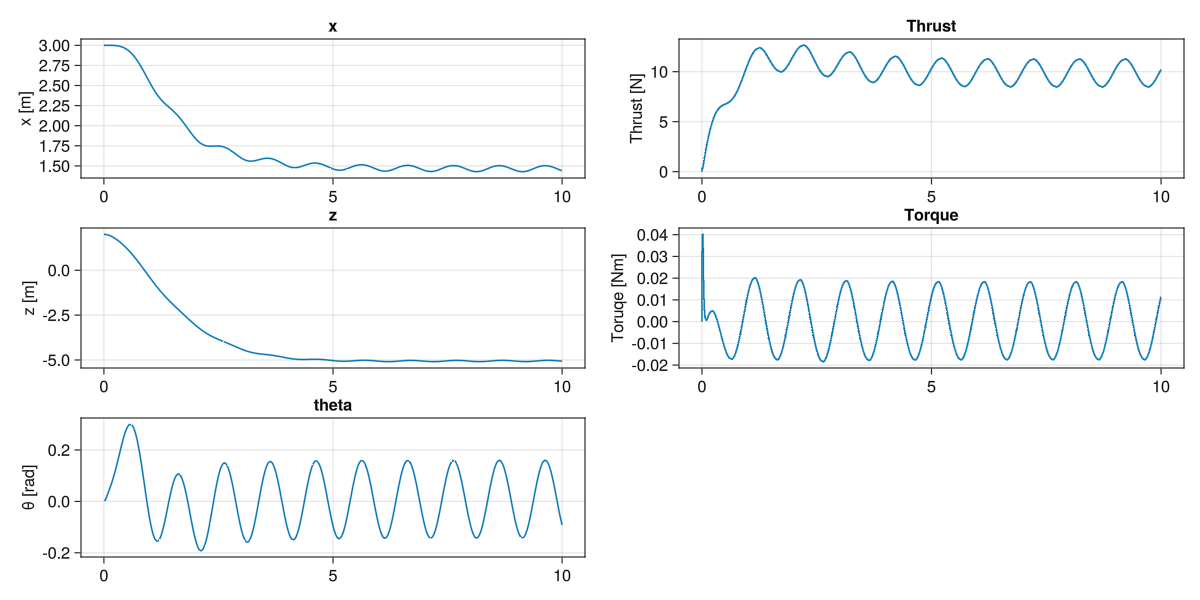

In [433]:
control_cb = PeriodicCallback(sim_params.Ts, initial_affect=true) do integrator
    p = integrator.p    # Extract the parameter object from the integrator
    nx = 6
    
    # Extract the parameters
    (; m, g, l, I_xx, safety_box, K) = params

    # Extract the state 
    X = integrator.u[1:sim_params.nx] 

    # compute trajectory tracking error
    X_req = generate_circle_trajectory(circle_trajec_params, integrator.t)

    X_error = X - X_req

    # println("X_req: $(X_req)")
    # println("X_error: $(X_error)")

    # compute control input
    U = - K * X_error

    f_1 = U[1]
    f_2 = U[2]

    # constrain the control input
    f_1 = clamp(f_1, quad_obj.motor_left.thrust_min, quad_obj.motor_left.thrust_max)
    f_2 = clamp(f_2, quad_obj.motor_right.thrust_min, quad_obj.motor_right.thrust_max)

    # println("Control: $(U)")
    
    #Update the control-signal
    integrator.u[sim_params.nx+1:end] .= SA_F64[f_1, f_2]
end

# parameters
params = (; m=quad_obj.m, g=-9.81, l=quad_obj.L, I_xx = 0.003, safety_box = safety_box, K=K)

#Initial Conditions
X₀ = Pose2D(3,2,0,0,0,0)

tspan = (0.0, 10.0);

initial_state = [X₀.y, X₀.z, X₀.θ, X₀.ẏ, X₀.ż, X₀.θ̇]; # state
u₀ = [0,0]; # control

initial_conditions = vcat(initial_state,u₀)

#Pass to solvers
cb_set = CallbackSet(control_cb,cb)
prob = ODEProblem(quad_2d, initial_conditions, tspan, params, callback=cb_set);
sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

quad_2d_plot_normal(sol)

## Forward-diff demo

In [365]:
let

x(r, ω, t) = 1 * cos(1*t)
x(var) = x(var[1],var[2], var[3])

ẋ_fdiff =  ForwardDiff.gradient(x, [1, 1, 0.5])

# compare with analytical derivative
ẋ(r, ω, t) = -r * sin(ω*t) * ω

ẋ_analytical = ẋ(1, 1, 0.5)

# show results 
println("ẋ Analytical: $(ẋ_analytical)")
println("ẋ Forward-diff: $(ẋ_fdiff)")

end

ẋ Analytical: -0.479425538604203
ẋ Forward-diff: [-0.0, -0.0, -0.479425538604203]


In [394]:
let 
include("trajectory_generation.jl")

t = 1.2 # seconds
(x_req, y_req, θ_req, ẋ_req, ẏ_req, θ̇_req) = generate_circle_trajectory(circle_trajec_params, t)

end

6-element Vector{Float64}:
 2.309016994374948
 2.9510565162951536
 0.10158590543965393
 0.0
 0.0
 0.0